In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import csv

In [113]:
def read_data(data_path):
    pos = []
    vel = []
    with open(data_path) as csvfile:
        data = csv.reader(csvfile, delimiter=",", skipinitialspace=True)
        run = False
        for row in data:
            if row == ["$$SOE"]: 
                run=True
                continue
            if row == ["$$EOE"]: run=False
            if run:
                pos.append(row[2:5])
                vel.append(row[5:8])

    return np.asarray(pos).astype(float), np.asarray(vel).astype(float)

In [138]:
sun_q, sun_p = read_data("data/horizons_sun.txt")
mercury_q, mercury_p = read_data("data/horizons_mercury.txt")
venus_q, venus_p = read_data("data/horizons_venus.txt")
earth_q, earth_p = read_data("data/horizons_earth.txt")
mars_q, mars_p = read_data("data/horizons_mars.txt")


Text(0.5, 0.98, 'Phase spaces')

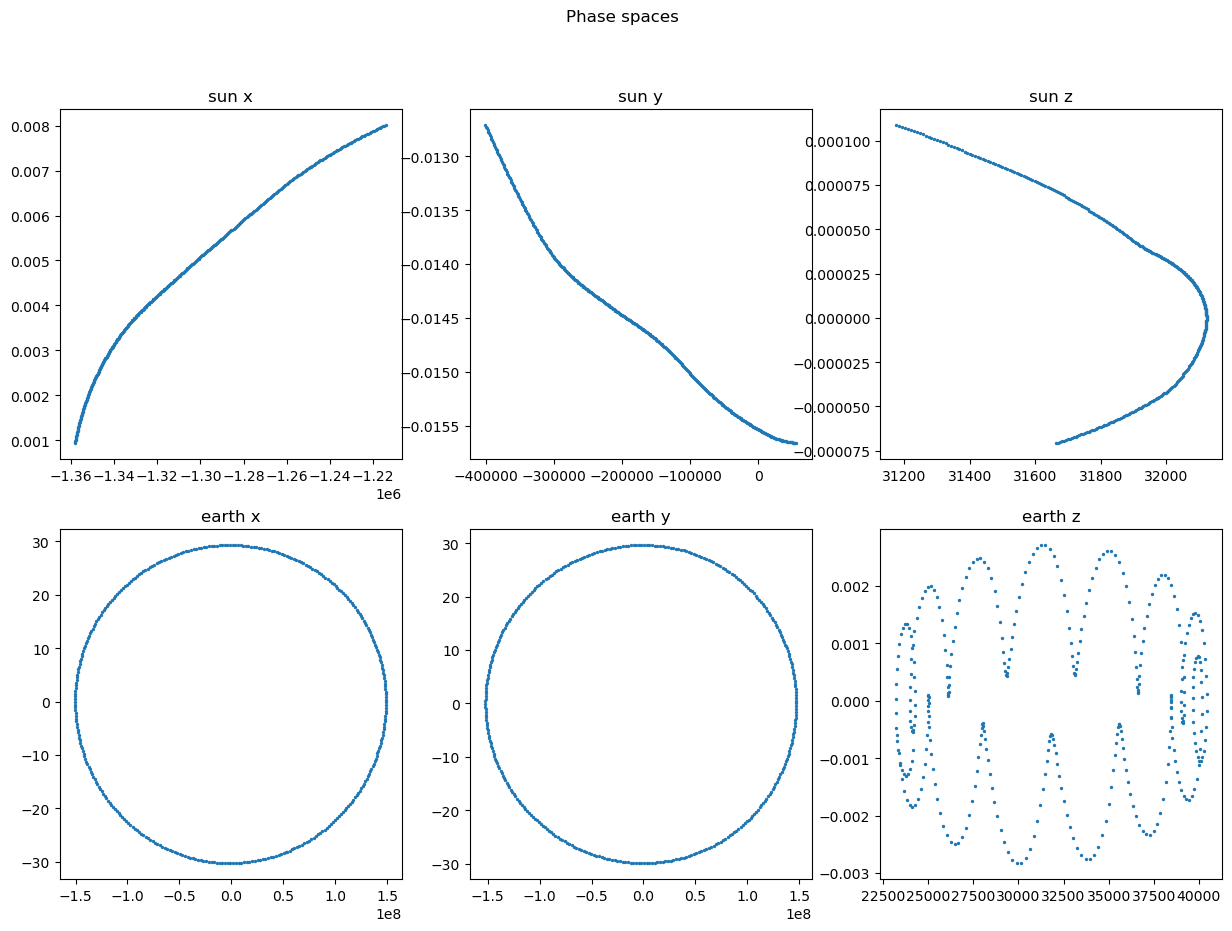

In [154]:
fig, axs = plt.subplots(2,3, figsize=(15,10))
coords = ["x", "y", "z"]

for i in range(0, 3):
    axs[0, i].scatter(sun_q.T[i], sun_p.T[i], s=2)
    axs[0, i].set_title("sun " + coords[i])
    axs[1, i].scatter(earth_q.T[i], earth_p.T[i], s=2)
    axs[1, i].set_title("earth " + coords[i])

fig.suptitle("Phase spaces")

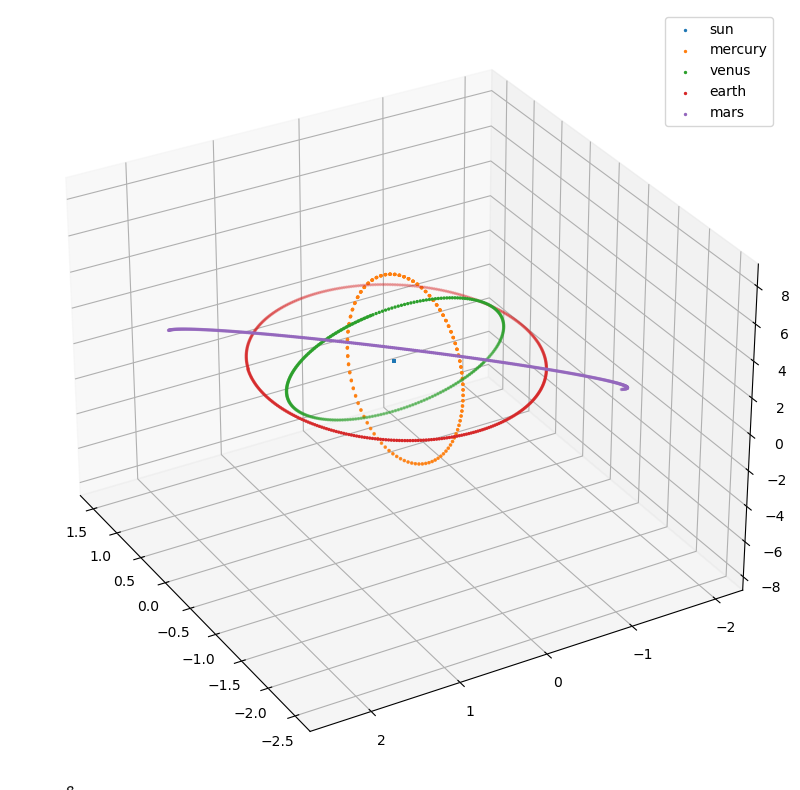

In [149]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
ax = fig.add_subplot(projection='3d')

ax.scatter(sun_q.T[0], sun_q.T[1], sun_q.T[2], s=2, label="sun")
ax.scatter(mercury_q.T[0], mercury_q.T[1], mercury_q.T[2], s=2, label="mercury")
ax.scatter(venus_q.T[0], venus_q.T[1], venus_q.T[2], s=2, label="venus")
ax.scatter(earth_q.T[0], earth_q.T[1], earth_q.T[2], s=2, label="earth")
ax.scatter(mars_q.T[0], mars_q.T[1], mars_q.T[2], s=2, label="mars")
ax.view_init(azim=150)
plt.legend()
plt.show()